In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
import copy
# custom imports
import utils
import train
from mcts import *
from rtfm import featurizer as X
import os

Using device cuda:0
Using device cuda:0


In [2]:
# Check only if main logic of the training loop works
ucb_C = 1.0
discount = 0.9 # try with smaller discount
episode_length = 32
max_actions = 5
num_simulations = 100
device = device
n_episodes = 2000
memory_size = 528
batch_size = 32
n_steps = 5
tau = 0.5 # new_trg_params = (1-tau)*old_trg_params + tau*value_net_params
temperature = 1.

training_params = dict(
    ucb_C = 1.0,
    discount = 0.9,
    episode_length = 32,
    max_actions = 5,
    num_simulations = 100,
    device = device,
    n_episodes = 2000,
    memory_size = 528,
    batch_size = 32,
    n_steps = 5,
    tau = 0.5,
    temperature = 1.
)

In [3]:
flags = utils.Flags(env="rtfm:groups_simple_stationary-v0")
gym_env = utils.create_env(flags)
featurizer = X.Render()
game_simulator = FullTrueSimulator(gym_env, featurizer)

In [6]:
class FixedDynamicsPVNet(nn.Module):
    def __init__(self, 
                 gym_env,
                 emb_dim=10,
                ):
        super().__init__()
        self.name_embedding = nn.Embedding(len(gym_env.vocab), emb_dim)
        self.inv_embedding = nn.Embedding(len(gym_env.vocab), emb_dim)
        
        name_shape = gym_env.observation_space['name']
        inv_shape = gym_env.observation_space['inv']
        n_channels = (name_shape[2]*name_shape[3]+inv_shape[0])*emb_dim
        
        self.conv_net = nn.Sequential(
            nn.Conv2d(n_channels, 64, kernel_size=1),
            nn.ReLU(),
            nn.Conv2d(64, 128, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(128, 128, kernel_size=3, padding=1)
        )

        self.maxpool = nn.MaxPool2d(gym_env.observation_space['name'][1])

        self.value_mlp = nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,1)
        )
        
        self.policy_mlp = nn.Sequential(
            nn.Linear(128,128),
            nn.ReLU(),
            nn.Linear(128,len(gym_env.action_space))
        )
        
    def forward(self, frame):
        device = next(self.parameters()).device
        x = self.name_embedding(frame['name'].to(device))
        s = x.shape
        B, W, H = s[:3]
        x = x.reshape(*s[:3],-1).permute(0, 3, 1, 2)
        
        inv = self.inv_embedding(frame['inv'].to(device))
        inv = inv.reshape(B,-1,1,1)
        inv = inv.expand(B,-1,W,H)
        
        z = torch.cat([x,inv], axis=1)
        z_conv = self.conv_net(z)
        z_flat = self.maxpool(z_conv).view(B,-1)
        
        v = self.value_mlp(z_flat)
        logits = self.policy_mlp(z_flat)
        #print("logits: ", logits)
        action_mask = 1-frame['valid'].to(device)
        #print("action_mask: ", action_mask)
        probs = F.softmax(logits.masked_fill((action_mask).bool(), float('-inf')), dim=-1) 
        #print("probs: ", probs)
        return v, probs

In [8]:
class PolicyReplayBuffer:
    def __init__(self, mem_size):
        self.mem_size = mem_size
        self.frame_buffer = []
        self.probs_buffer = []
    
    def store_episode(self, frame_lst, probs_lst):
        frames, probs = self.batch_episode(frame_lst, probs_lst)
        self.frame_buffer.append(frames)
        self.probs_buffer.append(probs)
        if len(self.frame_buffer) > self.mem_size:
            self.frame_buffer.pop(0)
            self.probs_buffer.pop(0)
            
    def batch_episode(self, frame_lst, probs_lst):
        episode_len = len(reward_lst)
        frames = {}
        for k in frame_lst[0].keys():
            k_value_lst = []
            for b in range(episode_len): # this is a problem, since the frame_lst has one more state!!!
                k_value_lst.append(frame_lst[b][k])
            k_value_lst = torch.cat(k_value_lst, axis=0)
            frames[k] = k_value_lst.unsqueeze(0)
            
        probs = torch.tensor(probs_lst).float() # (T, A)
        
        return frames, probs.unsqueeze(0) #(1,T,A)
    
    def get_batch(self, batch_size):
        id_range = len(self.probs_buffer)
        assert id_range >= batch_size, "Not enough samples stored to get this batch size"
        sampled_ids = np.random.choice(id_range, size=batch_size, replace=False)
        sampled_probs = torch.cat([self.probs_buffer[i] for i in sampled_ids], axis=0)
        # batch together frames 
        sampled_frames = {}
        for k in self.frame_buffer[0].keys():
            key_values = torch.cat([self.frame_buffer[i][k] for i in sampled_ids], axis=0)
            sampled_frames[k] = key_values
            
        reshaped_frames = {}
        for k in sampled_frames.keys():
            shape = sampled_frames[k].shape
            reshaped_frames[k] = sampled_frames[k].reshape(-1,*shape[2:])
        
        reshaped_probs = sampled_probs.reshape(-1, sampled_probs.shape[-1]) #(B*T, A)
        return reshaped_frames, reshaped_probs

In [10]:
#training_dict = torch.load("saved/training_dict_n_steps_boot_100simul")
training_dict = torch.load("save_dir/policy_AAA/training_dict_600")
object_ids = training_dict["object_ids"]
pv_net = training_dict["pv_net"]
rb = training_dict["rb"]
losses = training_dict["losses"]
episodes_played = training_dict["episodes_played"]
training_params = training_dict["training_params"]
total_rewards = training_dict["total_rewards"]
n_steps = training_params["n_steps"]
perc_optimal_actions = training_dict["perc_optimal_actions"]

In [11]:
def plot_losses(losses):
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(len(losses)), losses)
    plt.xlabel("Number of optimizer steps", fontsize=16)
    plt.ylabel("Policy net cross entropy loss", fontsize=16)
    plt.show()
    
def plot_rewards(total_rewards):
    window = 20
    average_rewards = np.array([np.mean(total_rewards[i-window:i]) for i in range(window, len(total_rewards))])
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(len(average_rewards)), average_rewards, label="Moving average over %d rollouts"%window)
    plt.xlabel("Number of rollouts", fontsize=16)
    plt.ylabel("Average total reward in 32 steps", fontsize=16)
    plt.legend()
    plt.show()
    
def plot_action_optimality(perc_optimal_actions):
    plt.figure(figsize=(10,8))
    plt.plot(np.arange(len(perc_optimal_actions)), perc_optimal_actions)
    plt.xlabel("Number of optimizer steps", fontsize=16)
    plt.ylabel("Fraction of optimal actions per trajectory", fontsize=16)
    plt.show()

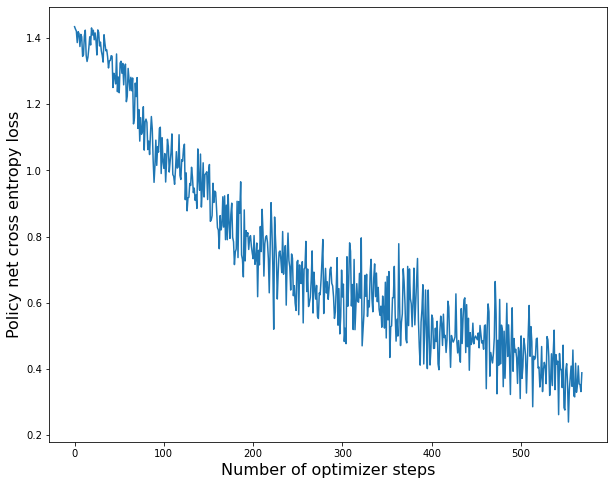

In [12]:
plot_losses(losses)

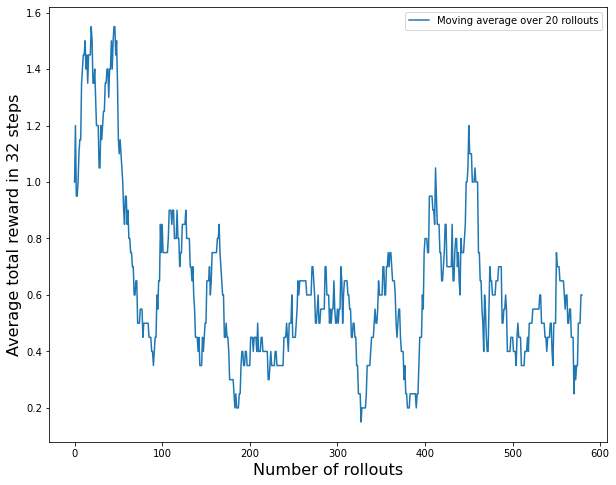

In [13]:
plot_rewards(total_rewards)

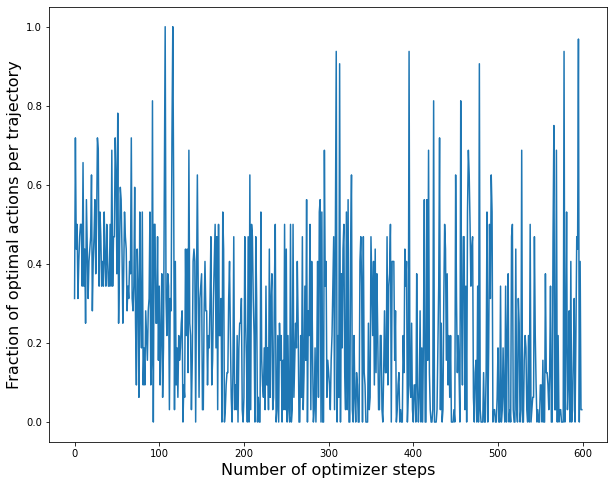

In [14]:
plot_action_optimality(perc_optimal_actions)